In [1]:
%load_ext autotime
%matplotlib inline

import goks.utils
# import keras
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import scipy.optimize
# import seaborn as sb
import sklearn as sk
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.manifold
import sklearn.metrics
import sklearn.tree
import xgboost as xgb

# load data

### rainfall

In [2]:
rdf = pd.read_csv( '../hko-gov/hourly_rainfall.csv' )
rdf[ 'date' ] = pd.to_datetime( rdf.apply( lambda x: '2016-{}-{} {}:0:0'.format( x[ 'month' ], x[ 'day' ], x[ 'hour' ] ), axis=1 ) )
print( rdf.shape )
rdf.head()

(7776, 6)


,month,day,hour,region,rainfall,date
0,5,10,10,Tai Po,36,2016-05-10 10:00:00
1,5,10,10,North District,30,2016-05-10 10:00:00
2,5,10,10,Sha Tin,30,2016-05-10 10:00:00
3,5,10,10,Kwai Tsing,22,2016-05-10 10:00:00
4,5,10,10,Yuen Long,20,2016-05-10 10:00:00


time: 316 ms


In [3]:
rdf.date.min(), rdf.date.max()

(Timestamp('2016-05-01 00:00:00'), Timestamp('2016-09-13 18:00:00'))

time: 4.42 ms


### warning

In [84]:
wdf = pd.read_csv( '../hko-gov/warn.csv', parse_dates=[ 'starttime', 'endtime' ] )
wdf[ 'duration' ] = wdf[ 'hours' ] * 60 + wdf[ 'minutes' ]
wdf[ 'st' ] = wdf.starttime.values.astype( '<M8[h]' )
wdf[ 'et' ] = wdf.endtime.values.astype( '<M8[h]' )
wdf = wdf.sort_values( [ 'st', 'signal' ] ).drop_duplicates( [ 'st' ], keep='last' )
print( wdf.shape )
wdf.head()

(30, 8)


,signal,starttime,endtime,hours,minutes,duration,st,et
0,Amber,2016-01-05 14:00:00,2016-01-05 14:45:00,0,45,45,2016-01-05 14:00:00,2016-01-05 14:00:00
1,Amber,2016-04-04 16:35:00,2016-04-04 19:25:00,2,50,170,2016-04-04 16:00:00,2016-04-04 19:00:00
2,Amber,2016-04-10 09:30:00,2016-04-10 11:40:00,2,10,130,2016-04-10 09:00:00,2016-04-10 11:00:00
3,Amber,2016-04-13 06:30:00,2016-04-13 12:00:00,5,30,330,2016-04-13 06:00:00,2016-04-13 12:00:00
4,Amber,2016-04-22 08:20:00,2016-04-22 09:45:00,1,25,85,2016-04-22 08:00:00,2016-04-22 09:00:00


time: 102 ms


# data massage

### rdf + wdf -> df

In [162]:
df = rdf.merge( wdf, how='outer', left_on='date', right_on='st' )
df[ 'amber' ] = ( df.rainfall >= 30 ) & ( df.rainfall < 50 )
df[ 'red' ] = ( df.rainfall >= 50 ) & ( df.rainfall < 70 )
df[ 'black' ] = df.rainfall >= 70
df[ 'amberp' ] = ( df.rainfall >= 30 )
df[ 'redp' ] = ( df.rainfall >= 50 )
df.signal.fillna( '--', inplace=True )
print( df.shape )
df.head()

(7781, 19)


,month,day,hour,region,rainfall,date,signal,starttime,endtime,hours,minutes,duration,st,et,amber,red,black,amberp,redp
0,5.0,10.0,10.0,Tai Po,36.0,2016-05-10 10:00:00,--,NaT,NaT,NaN,NaN,NaN,NaT,NaT,True,False,False,True,False
1,5.0,10.0,10.0,North District,30.0,2016-05-10 10:00:00,--,NaT,NaT,NaN,NaN,NaN,NaT,NaT,True,False,False,True,False
2,5.0,10.0,10.0,Sha Tin,30.0,2016-05-10 10:00:00,--,NaT,NaT,NaN,NaN,NaN,NaT,NaT,True,False,False,True,False
3,5.0,10.0,10.0,Kwai Tsing,22.0,2016-05-10 10:00:00,--,NaT,NaT,NaN,NaN,NaN,NaT,NaT,False,False,False,False,False
4,5.0,10.0,10.0,Yuen Long,20.0,2016-05-10 10:00:00,--,NaT,NaT,NaN,NaN,NaN,NaT,NaT,False,False,False,False,False


time: 37.7 ms


### wdf -> hwdf - fill missing rows where signal is raised

In [86]:
hwdf = [ [ x[ 0 ], d ] for x in wdf.iterrows() for d in pd.date_range( x[ 1 ][ 'st' ], x[ 1 ][ 'et' ], freq='H' ) ]
hwdf = pd.MultiIndex.from_tuples( hwdf, names=[ 'i', 'date'] )
hwdf = wdf.set_index( 'st', append=True )[ [ 'signal' ] ].reindex( hwdf )
hwdf = hwdf.fillna( method='ffill' ).reset_index().drop( 'i', axis=1 )
hwdf = hwdf.sort_values( [ 'date', 'signal' ] ).drop_duplicates( subset='date', keep='last' )
hwdf.head()

,date,signal
0,2016-01-05 14:00:00,Amber
1,2016-04-04 16:00:00,Amber
2,2016-04-04 17:00:00,Amber
3,2016-04-04 18:00:00,Amber
4,2016-04-04 19:00:00,Amber


time: 70.7 ms


### rdf + hwdf -> hdf

In [166]:
hdf = rdf.merge( hwdf, how='left', on='date' )
hdf[ 'amber' ] = ( hdf.rainfall >= 30 ) & ( hdf.rainfall < 50 )
hdf[ 'red' ] = ( hdf.rainfall >= 50 ) & ( hdf.rainfall < 70 )
hdf[ 'black' ] = hdf.rainfall >= 70
hdf[ 'amberp' ] = ( hdf.rainfall >= 30 )
hdf[ 'redp' ] = ( hdf.rainfall >= 50 )
hdf.signal.fillna( '--', inplace=True )
print( hdf.shape )
hdf.head()

(7776, 12)


,month,day,hour,region,rainfall,date,signal,amber,red,black,amberp,redp
0,5,10,10,Tai Po,36,2016-05-10 10:00:00,Amber,True,False,False,True,False
1,5,10,10,North District,30,2016-05-10 10:00:00,Amber,True,False,False,True,False
2,5,10,10,Sha Tin,30,2016-05-10 10:00:00,Amber,True,False,False,True,False
3,5,10,10,Kwai Tsing,22,2016-05-10 10:00:00,Amber,False,False,False,False,False
4,5,10,10,Yuen Long,20,2016-05-10 10:00:00,Amber,False,False,False,False,False


time: 31 ms


### hdf -> ghdf - aggregated hdf

In [168]:
ghdf = hdf.groupby( hdf.date ).agg( { 'signal': 'max', 'rainfall': [ 'sum', 'max', 'mean' ], 'amber': 'sum', 'red': 'sum', 'black': 'sum', 'amberp': 'sum', 'redp': 'sum' } )
ghdf_cols = [ '_'.join( col ).strip( '_' ) for col in ghdf.columns.values ]
ghdf = pd.DataFrame( ghdf.to_records() )
ghdf.columns = np.concatenate( [ [ 'date' ], ghdf_cols ] )
print( ghdf.shape )
ghdf.head()

(1158, 10)


,date,amber_sum,redp_sum,red_sum,signal_max,black_sum,rainfall_sum,rainfall_max,rainfall_mean,amberp_sum
0,2016-05-01 00:00:00,0.0,0.0,0.0,--,0.0,66,9,4.125000,0.0
1,2016-05-01 01:00:00,0.0,0.0,0.0,--,0.0,5,3,1.666667,0.0
2,2016-05-01 02:00:00,0.0,0.0,0.0,--,0.0,3,3,3.000000,0.0
3,2016-05-01 03:00:00,0.0,0.0,0.0,--,0.0,44,5,3.142857,0.0
4,2016-05-01 04:00:00,0.0,0.0,0.0,--,0.0,21,9,4.200000,0.0


time: 217 ms


# analysis
- number of affected areas
- rainfall amount
- rainfall period

### rainfall amount

In [208]:
t = ghdf.merge( wdf, how='left', left_on='date', right_on='st' )
t = t[ ( t.signal_max != 'Red' ) | ( t.signal == 'Red' ) ]
print( t.shape )
t.head()

(1150, 18)


,date,amber_sum,redp_sum,red_sum,signal_max,black_sum,rainfall_sum,rainfall_max,rainfall_mean,amberp_sum,signal,starttime,endtime,hours,minutes,duration,st,et
0,2016-05-01 00:00:00,0.0,0.0,0.0,--,0.0,66,9,4.125000,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT
1,2016-05-01 01:00:00,0.0,0.0,0.0,--,0.0,5,3,1.666667,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT
2,2016-05-01 02:00:00,0.0,0.0,0.0,--,0.0,3,3,3.000000,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT
3,2016-05-01 03:00:00,0.0,0.0,0.0,--,0.0,44,5,3.142857,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT
4,2016-05-01 04:00:00,0.0,0.0,0.0,--,0.0,21,9,4.200000,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaT


time: 33.6 ms


In [147]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_sum' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'rainfall_sum' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       0.75      0.75      0.75         4

avg / total       1.00      1.00      1.00      1150

584.5
time: 7.31 ms


In [148]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_max' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'rainfall_max' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       0.00      0.00      0.00         4

avg / total       0.99      1.00      0.99      1150

68.0
time: 11.9 ms


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [149]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_mean' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'rainfall_mean' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       0.75      0.75      0.75         4

avg / total       1.00      1.00      1.00      1150

37.6111106873
time: 7.52 ms


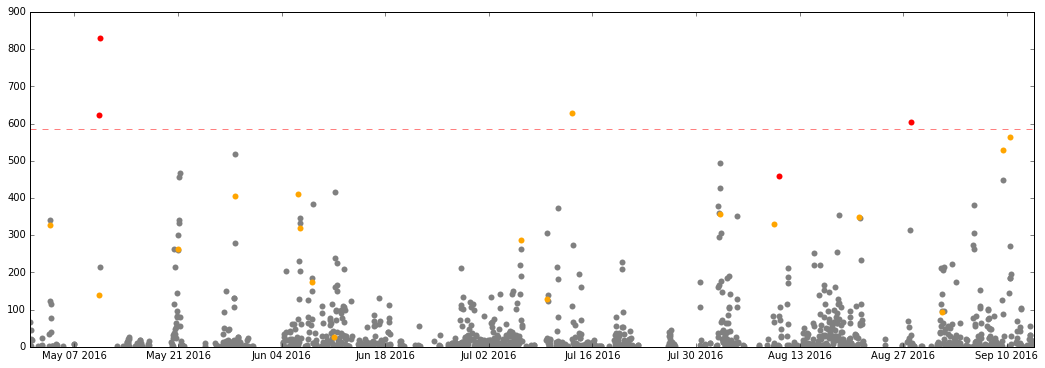

time: 293 ms


In [115]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_sum, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_sum, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_sum, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 584.5, color='red', linestyle='--', alpha=.5 )

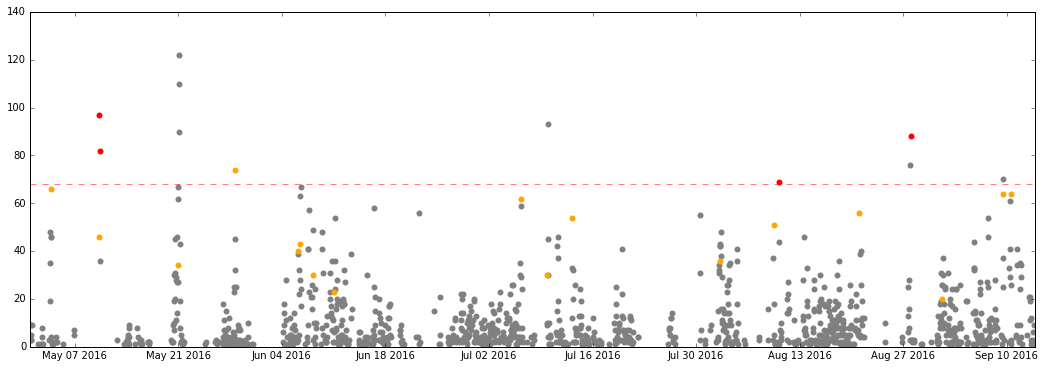

time: 273 ms


In [117]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_max, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_max, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_max, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 68, color='red', linestyle='--', alpha=.5 )

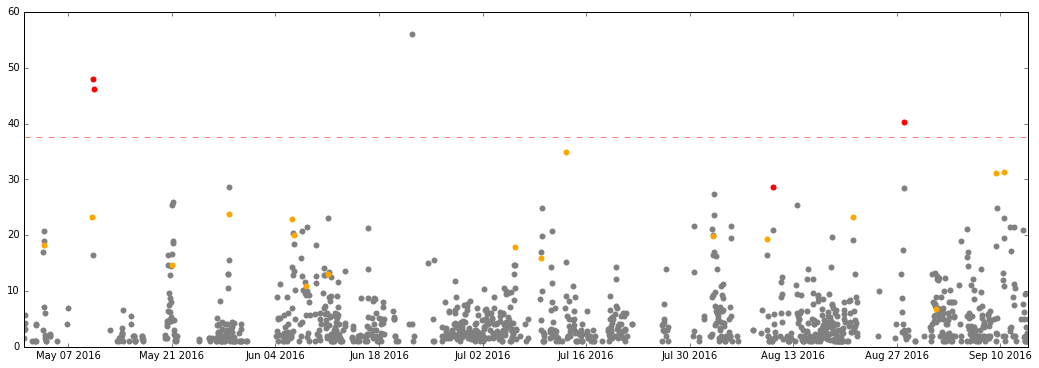

time: 275 ms


In [118]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_mean, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_mean, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_mean, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 37.6111106873, color='red', linestyle='--', alpha=.5 )

In [150]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_sum', 'rainfall_max', 'rainfall_mean' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'rainfall_sum', 'rainfall_max', 'rainfall_mean' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       0.75      0.75      0.75         4

avg / total       1.00      1.00      1.00      1150

(1, 2, 0, 584.5, 0.006932325141776885, 1150, 1150.0)
time: 9.9 ms


### rainfall coverage

In [119]:
# t = ghdf.merge( wdf, how='left', left_on='date', right_on='st' )
# t = t[ ( t.signal_max != 'Red' ) | ( t.signal == 'Red' ) ]
# print( t.shape )
# t.head()

time: 907 µs


In [170]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'redp_sum' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'redp_sum' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00      1150

4.0
time: 13 ms


In [171]:
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'amberp_sum' ] ], t.signal == 'Red' )
p = k.predict_proba( t[ [ 'amberp_sum' ] ] )
print( sk.metrics.classification_report( t.signal == 'Red', np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1146
       True       0.00      0.00      0.00         4

avg / total       0.99      1.00      0.99      1150

6.5
time: 9.01 ms


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


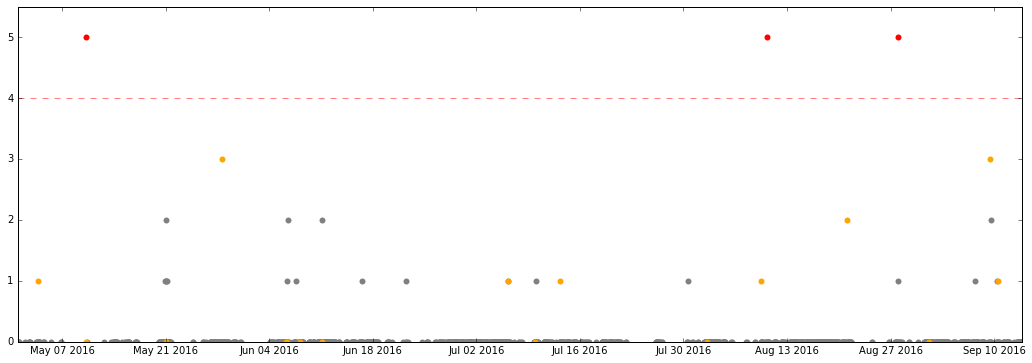

time: 285 ms


In [173]:
pt.figure( figsize=( 18, 6 ) )
pt.ylim( ( 0, 5.5 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].redp_sum, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].redp_sum, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].redp_sum, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 4, color='red', linestyle='--', alpha=.5 )

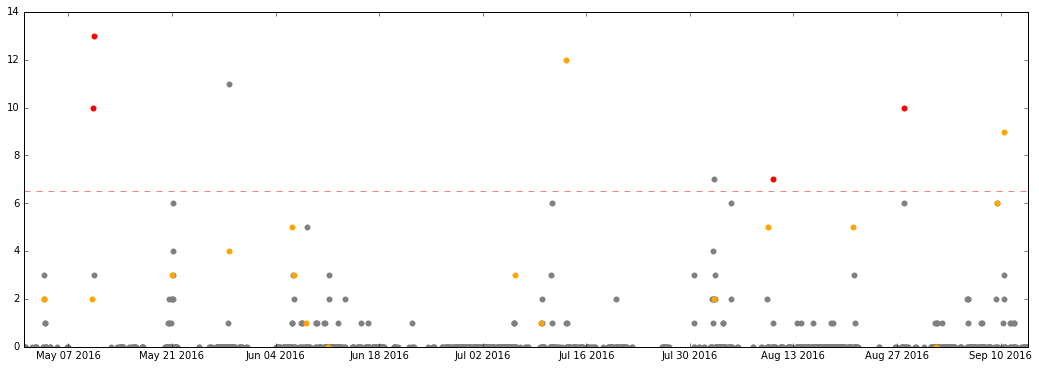

time: 264 ms


In [146]:
pt.figure( figsize=( 18, 6 ) )
# pt.ylim( ( -.5, 5.5 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].amberp_sum, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].amberp_sum, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].amberp_sum, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 6.5, color='red', linestyle='--', alpha=.5 )

### rainfall duration

In [212]:
t = ghdf.merge( wdf, how='left', left_on='date', right_on='st' )
# t[ t.amberp_sum > 0 ].head()

time: 4.9 ms


In [213]:
# t[ 'amberp_cumsum' ] = ( t.amberp_sum > 0 ).astype( int )
# t[ 'amberp_cumsum' ] = t.amberp_cumsum * t.amberp_cumsum * t.amberp_cumsum.groupby( ( ( t.amberp_cumsum != t.amberp_cumsum.shift() ) ).cumsum() ).cumcount( ascending=False )
t[ 'redp_cumsum' ] = ( t.redp_sum > 0 ).astype( int )
t[ 'redp_cumsum' ] = t.redp_cumsum * t.redp_cumsum * t.redp_cumsum.groupby( ( ( t.redp_cumsum != t.redp_cumsum.shift() ) ).cumsum() ).cumcount( ascending=False )

time: 7.05 ms


In [197]:
# t[ t.amberp_cumsum > 1 ][ [ 'date', 'signal_max', 'amberp_cumsum' ] ]

time: 645 µs


In [214]:
t[ t.signal == 'Red' ].redp_cumsum.mean()

0.75

time: 5.9 ms


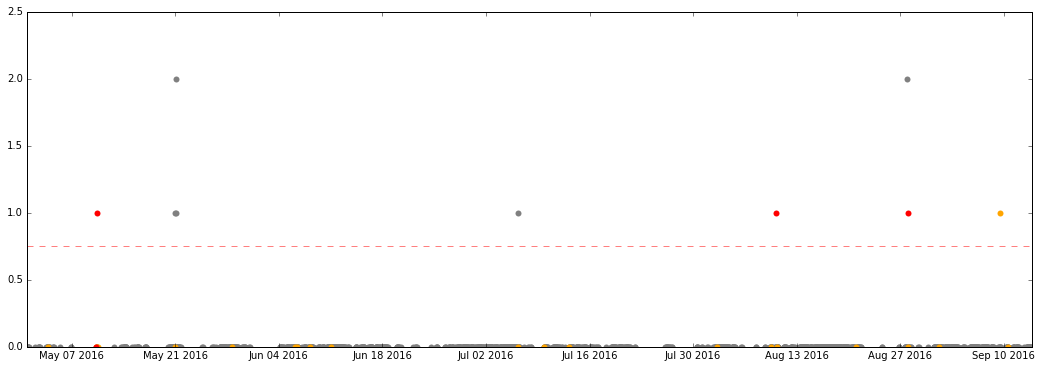

time: 252 ms


In [219]:
pt.figure( figsize=( 18, 6 ) )
pt.ylim( ( 0, 2.5 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].redp_cumsum, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].st, t[ t.signal == 'Amber' ].redp_cumsum, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].st, t[ t.signal == 'Red' ].redp_cumsum, color='red', mew=0 )
pt.axhline( .75, color='red', linestyle='--', alpha=.5 )

In [206]:
t = wdf[ wdf.st >= rdf.date.min() ]
print( 'mean', t[ t.signal == 'Red' ].duration.mean() )
print( 'min', t[ t.signal == 'Red' ].duration.min() )
print( 'max', t[ t.signal == 'Red' ].duration.max() )
print( 'std', t[ t.signal == 'Red' ].duration.std() )

mean 118.75
min 100
max 145
std 19.3110503771
time: 9.5 ms


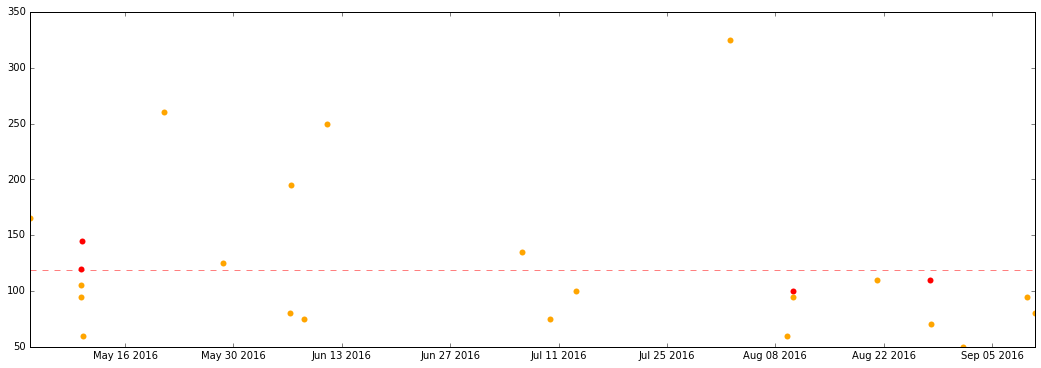

time: 231 ms


In [159]:
pt.figure( figsize=( 18, 6 ) )
# pt.plot_date( wdf[ wdf.signal == 'Red' ].st, wdf[ wdf.signal == 'Red' ].duration, color='red', mew=0 )
# pt.plot_date( wdf[ wdf.signal == 'Amber' ].st, wdf[ wdf.signal == 'Amber' ].duration, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].st, t[ t.signal == 'Amber' ].duration, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].st, t[ t.signal == 'Red' ].duration, color='red', mew=0 )
pt.axhline( 118.75, color='red', linestyle='--', alpha=.5 )

# explore

### max rainfall in various regions when red signal is raised

In [11]:
df[ df.signal == 'Red' ].groupby( [ 'region', 'st' ] ).rainfall.max().unstack().reset_index()

st,region,2016-05-10 07:00:00,2016-05-10 11:00:00,2016-08-10 06:00:00,2016-08-28 00:00:00
0,Central & Western District,NaN,44.0,19.0,14.0
1,Eastern District,NaN,28.0,NaN,NaN
2,Islands District,3.0,43.0,66.0,61.0
3,Kowloon City,24.0,64.0,2.0,61.0
4,Kwai Tsing,42.0,63.0,54.0,35.0
5,Kwun Tong,7.0,64.0,NaN,1.0
6,North District,47.0,10.0,6.0,41.0
7,Sai Kung,58.0,82.0,1.0,NaN
8,Sha Tin,97.0,71.0,32.0,88.0
9,Sham Shui Po,34.0,63.0,22.0,51.0


time: 142 ms


In [12]:
hdf[ hdf.signal == 'Red' ].groupby( [ 'region', 'date' ] ).rainfall.max().unstack().reset_index()

date,region,2016-05-10 07:00:00,2016-05-10 08:00:00,2016-05-10 09:00:00,2016-05-10 11:00:00,2016-05-10 12:00:00,2016-05-10 13:00:00,2016-08-10 06:00:00,2016-08-10 07:00:00,2016-08-10 08:00:00,2016-08-28 00:00:00,2016-08-28 01:00:00,2016-08-28 02:00:00
0,Central & Western District,NaN,1.0,NaN,44.0,32.0,NaN,19.0,21.0,5.0,14.0,33.0,3.0
1,Eastern District,NaN,NaN,NaN,28.0,40.0,7.0,NaN,17.0,4.0,NaN,NaN,5.0
2,Islands District,3.0,NaN,1.0,43.0,45.0,9.0,66.0,13.0,9.0,61.0,26.0,3.0
3,Kowloon City,24.0,2.0,NaN,64.0,28.0,NaN,2.0,31.0,4.0,61.0,3.0,3.0
4,Kwai Tsing,42.0,5.0,NaN,63.0,11.0,NaN,54.0,26.0,5.0,35.0,26.0,5.0
5,Kwun Tong,7.0,4.0,NaN,64.0,38.0,2.0,NaN,40.0,5.0,1.0,NaN,5.0
6,North District,47.0,16.0,23.0,10.0,9.0,2.0,6.0,46.0,16.0,41.0,36.0,16.0
7,Sai Kung,58.0,44.0,NaN,82.0,24.0,3.0,1.0,65.0,15.0,NaN,30.0,25.0
8,Sha Tin,97.0,15.0,NaN,71.0,12.0,1.0,32.0,94.0,8.0,88.0,63.0,9.0
9,Sham Shui Po,34.0,1.0,NaN,63.0,23.0,NaN,22.0,27.0,4.0,51.0,9.0,5.0


time: 74.7 ms


### max rainfall

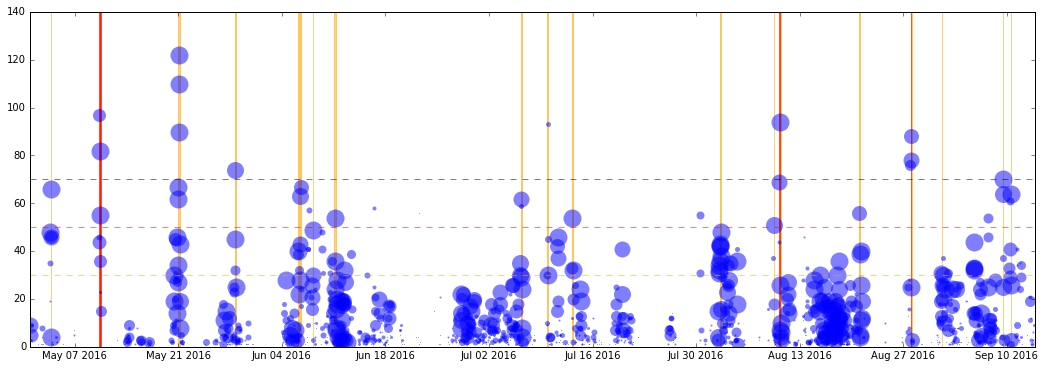

time: 10.4 s


In [13]:
t = rdf.groupby( 'date', as_index=False ).agg( { 'rainfall': 'max', 'region': 'count' } )
fig = pt.figure( figsize=( 18, 6 ) )
for x in t.region.unique():
    pt.plot_date( t[ t.region == x ].date, t[ t.region == x ].rainfall, markersize=x, markeredgewidth=0, c='blue', alpha=.5 )
t = wdf[ wdf.st >= t.date.min() ]
for x1, x2 in zip( t[ t.signal == 'Amber' ].st, t[ t.signal == 'Amber' ].et ):
    pt.axvspan( x1, x2, color='orange', alpha=.5 )
for x1, x2 in zip( t[ t.signal == 'Red' ].st, t[ t.signal == 'Red' ].et ):
    pt.axvspan( x1, x2, color='red', alpha=.5 )
pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 50, color='red', linestyle='--', alpha=.5 )
pt.axhline( 70, color='black', linestyle='--', alpha=.5 )

### mean rainfall

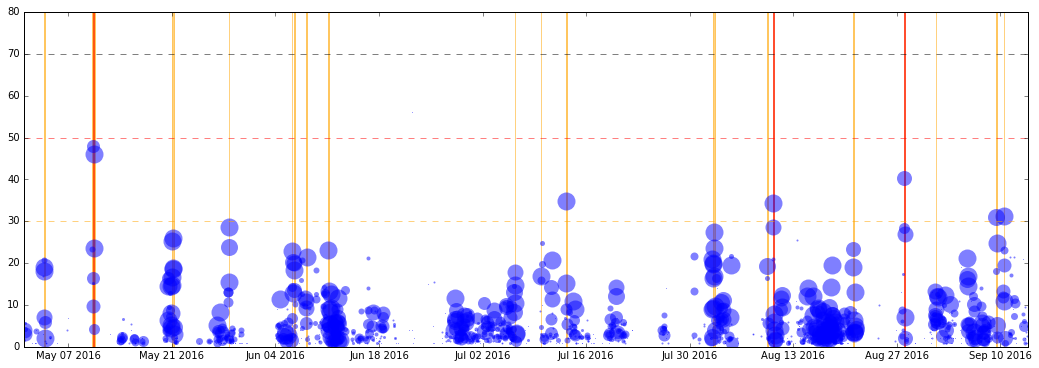

time: 36.6 s


In [14]:
t = rdf.groupby( 'date', as_index=False ).agg( { 'rainfall': 'mean', 'region': 'count' } )
fig = pt.figure( figsize=( 18, 6 ) )
for x in t.region.unique():
    pt.plot_date( t[ t.region == x ].date, t[ t.region == x ].rainfall, markersize=x, markeredgewidth=0, c='blue', alpha=.5 )
t = wdf[ wdf.st >= t.date.min() ]
for x1, x2 in zip( t[ t.signal == 'Amber' ].st, t[ t.signal == 'Amber' ].et ):
    pt.axvspan( x1, x2, color='orange', alpha=.5 )
for x1, x2 in zip( t[ t.signal == 'Red' ].st, t[ t.signal == 'Red' ].et ):
    pt.axvspan( x1, x2, color='red', alpha=.5 )
pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 50, color='red', linestyle='--', alpha=.5 )
pt.axhline( 70, color='black', linestyle='--', alpha=.5 )

### total rainfall

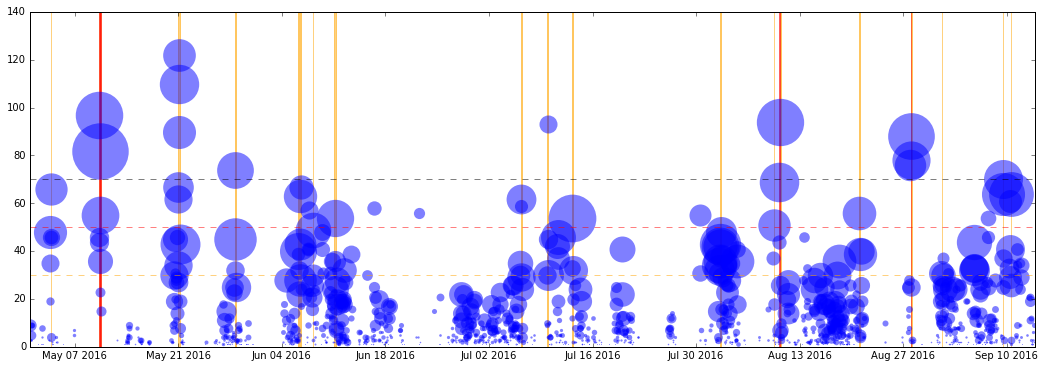

time: 1.25 s


In [223]:
t = ghdf.merge( wdf, how='left', left_on='date', right_on='st' )
pt.figure( figsize=( 18, 6 ) )
for x in t.rainfall_sum.unique():
    pt.plot_date( t[ t.rainfall_sum == x ].date, t[ t.rainfall_sum == x ].rainfall_max, ms=np.power( x, .6 ), mew=0, c='blue', alpha=.5 )
for x1, x2 in zip( t[ t.signal == 'Amber' ].st, t[ t.signal == 'Amber' ].et ):
    pt.axvspan( x1, x2, color='orange', alpha=.5 )
for x1, x2 in zip( t[ t.signal == 'Red' ].st, t[ t.signal == 'Red' ].et ):
    pt.axvspan( x1, x2, color='red', alpha=.5 )
pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 50, color='red', linestyle='--', alpha=.5 )
pt.axhline( 70, color='black', linestyle='--', alpha=.5 )

### how long does high rainfall keep after red signal has been raised

In [224]:
def chart1( hdf, d1, d2 ):
    t = hdf[ ( hdf.date >= d1 ) & ( hdf.date <= d2 ) ]
    t = t.sort_values( 'date' )
    pt.figure( figsize=( 18, 6 ) )
    for x in t.region.unique():
        pt.plot_date( t[ t.region == x ].date, t[ t.region == x ].rainfall, '-', alpha=.5 )
    for x in t[ t.signal == 'Amber' ].date.unique():
        pt.axvspan( x, x + pd.to_timedelta( 1, unit='h' ), color='orange', alpha=.1 )
    for x in t[ t.signal == 'Red' ].date.unique():
        pt.axvspan( x, x + pd.to_timedelta( 1, unit='h' ), color='red', alpha=.1 )
    t = t.groupby( 'date', as_index=False ).rainfall.mean()
    pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
    pt.axhline( 50, color='red', linestyle='--', alpha=.5 )
    pt.axhline( 70, color='black', linestyle='--', alpha=.5 )
#     pt.plot_date( t.date, t.rainfall, '--', linewidth=3, c='black' )

time: 12.2 ms


In [225]:
t = hdf[ ( hdf.date >= '2016-5-10 5:0:0' ) & ( hdf.date <= '2016-5-10 15:0:0' ) ].copy()
t = t.groupby( 'date', as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()#.plot( color=[ 'orange', 'red', 'black' ], kind='area', figsize=( 18, 6 ) )
t

,date,amber,red,black,rainfall
0,2016-05-10 06:00:00,2.0,0.0,0.0,140
1,2016-05-10 07:00:00,5.0,1.0,4.0,623
2,2016-05-10 08:00:00,1.0,0.0,0.0,138
3,2016-05-10 09:00:00,0.0,0.0,0.0,46
4,2016-05-10 10:00:00,3.0,0.0,0.0,215
5,2016-05-10 11:00:00,6.0,5.0,2.0,831
6,2016-05-10 12:00:00,5.0,1.0,0.0,424
7,2016-05-10 13:00:00,0.0,0.0,0.0,47


time: 26.6 ms


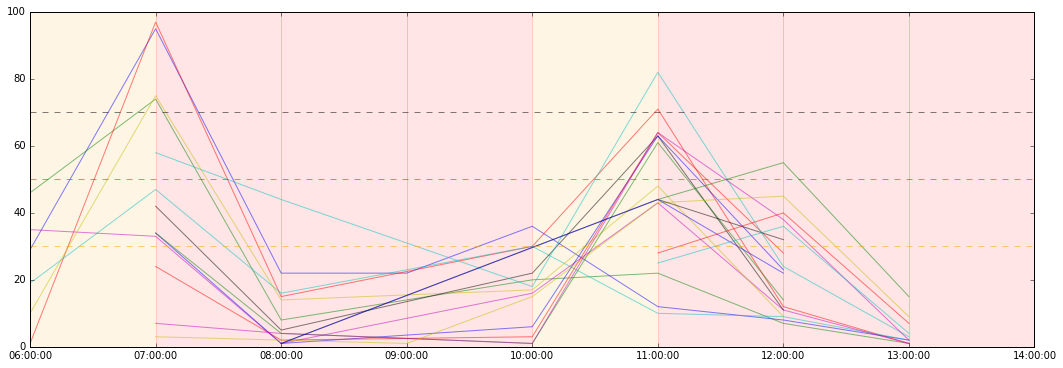

time: 381 ms


In [226]:
chart1( hdf, '2016-5-10 5:0:0', '2016-5-10 15:0:0' )

In [227]:
t = hdf[ ( hdf.date >= '2016-8-10 4:0:0' ) & ( hdf.date <= '2016-8-10 13:0:0' ) ].copy()
t = t.groupby( 'date', as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()#.plot( color=[ 'orange', 'red', 'black' ], kind='area', figsize=( 18, 6 ) )
t

,date,amber,red,black,rainfall
0,2016-08-10 04:00:00,0.0,0.0,0.0,1
1,2016-08-10 05:00:00,1.0,0.0,0.0,84
2,2016-08-10 06:00:00,2.0,5.0,0.0,459
3,2016-08-10 07:00:00,4.0,1.0,2.0,619
4,2016-08-10 08:00:00,0.0,0.0,0.0,139
5,2016-08-10 09:00:00,0.0,0.0,0.0,107
6,2016-08-10 10:00:00,0.0,0.0,0.0,72
7,2016-08-10 11:00:00,0.0,0.0,0.0,49
8,2016-08-10 12:00:00,0.0,0.0,0.0,29
9,2016-08-10 13:00:00,0.0,0.0,0.0,26


time: 17.5 ms


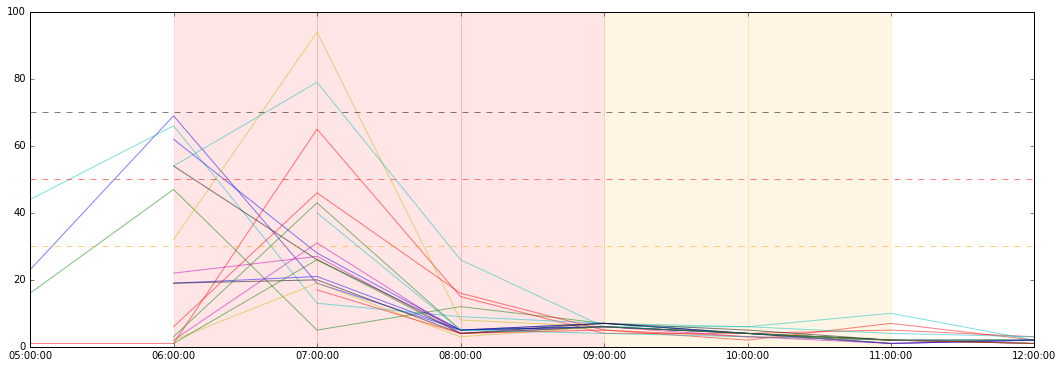

time: 339 ms


In [229]:
chart1( hdf, '2016-8-10 5:0:0', '2016-8-10 12:0:0' )

In [230]:
t = hdf[ ( hdf.date >= '2016-8-27 22:0:0' ) & ( hdf.date <= '2016-8-28 7:0:0' ) ].copy()
t = t.groupby( 'date', as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()#.plot( color=[ 'orange', 'red', 'black' ], kind='area', figsize=( 18, 6 ) )
t

,date,amber,red,black,rainfall
0,2016-08-27 22:00:00,0.0,0.0,0.0,3
1,2016-08-27 23:00:00,5.0,0.0,1.0,313
2,2016-08-28 00:00:00,5.0,4.0,1.0,605
3,2016-08-28 01:00:00,3.0,2.0,1.0,432
4,2016-08-28 02:00:00,0.0,0.0,0.0,128
5,2016-08-28 03:00:00,0.0,0.0,0.0,31
6,2016-08-28 04:00:00,0.0,0.0,0.0,9
7,2016-08-28 05:00:00,0.0,0.0,0.0,7


time: 16.4 ms


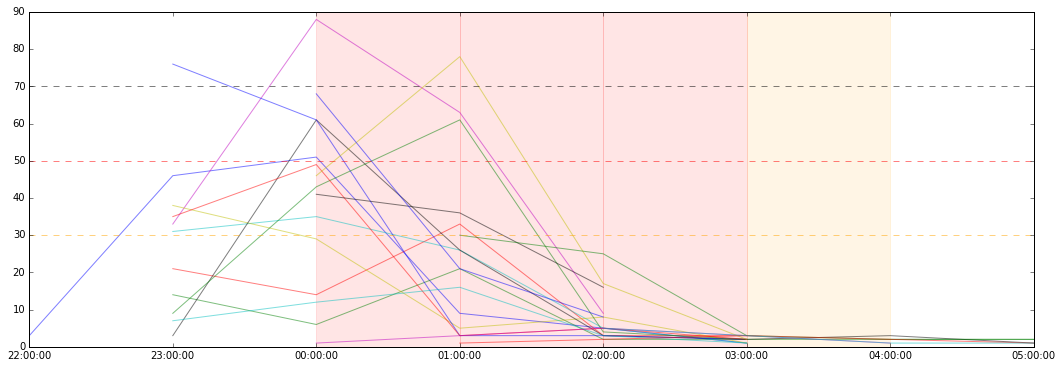

time: 519 ms


In [231]:
chart1( hdf, '2016-8-27 22:0:0', '2016-8-28 7:0:0' )

# why isn't red signal raised on 21/5?

In [23]:
t = hdf[ ( hdf.date >= '2016-5-20 23:0:0' ) & ( hdf.date <= '2016-5-21 9:0:0' ) ].copy()
t = t.groupby( 'date', as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()#.plot( color=[ 'orange', 'red', 'black' ], kind='area', figsize=( 18, 6 ) )
t

,date,amber,red,black,rainfall
0,2016-05-20 23:00:00,1.0,1.0,0.0,261
1,2016-05-21 00:00:00,1.0,1.0,0.0,300
2,2016-05-21 01:00:00,3.0,0.0,0.0,264
3,2016-05-21 02:00:00,4.0,1.0,1.0,456
4,2016-05-21 03:00:00,2.0,0.0,1.0,334
5,2016-05-21 04:00:00,1.0,0.0,1.0,340
6,2016-05-21 05:00:00,4.0,0.0,0.0,467
7,2016-05-21 06:00:00,0.0,0.0,0.0,81
8,2016-05-21 07:00:00,0.0,0.0,0.0,55
9,2016-05-21 08:00:00,0.0,0.0,0.0,16


time: 24.9 ms


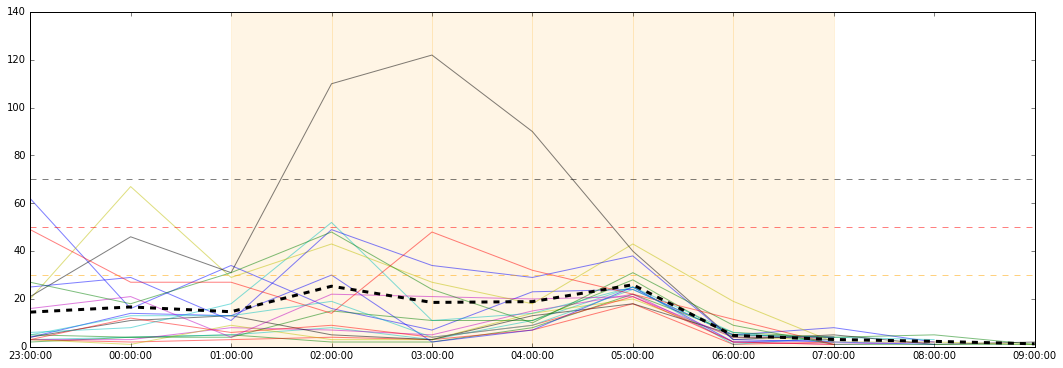

time: 559 ms


In [24]:
chart1( hdf, '2016-5-20 23:0:0', '2016-5-21 9:0:0' )

# condition 1
- total hourly rainfall
- max hourly rainfall
- average hourly rainfall

In [68]:
t = rdf.merge( hwdf[ hwdf.signal == 'Red' ], how='left', on='date' )
t[ 'signal' ] = t.signal.fillna( '--' )
t = t.groupby( [ 'date', 'signal' ] ).agg( { 'rainfall': [ 'sum', 'max', 'mean' ] } )
t_cols = [ '_'.join( col ).strip( '_' ) for col in t.columns.values ]
t = pd.DataFrame( t.to_records() )
t.columns = np.concatenate( [ [ 'date', 'signal' ], t_cols ] )
t = t.merge( wdf[ [ 'signal', 'st' ] ].groupby( 'st', as_index=False ).max(), how='left', left_on='date', right_on='st', suffixes=[ '_', '' ] )
t = t[ ( t.signal_ == '--' ) | pd.notnull( t.signal ) ]
print( t.shape )
t.head()

(1154, 7)


,date,signal_,rainfall_sum,rainfall_max,rainfall_mean,st,signal
0,2016-05-01 00:00:00,--,66,9,4.125000,NaT,NaN
1,2016-05-01 01:00:00,--,5,3,1.666667,NaT,NaN
2,2016-05-01 02:00:00,--,3,3,3.000000,NaT,NaN
3,2016-05-01 03:00:00,--,44,5,3.142857,NaT,NaN
4,2016-05-01 04:00:00,--,21,9,4.200000,NaT,NaN


time: 85.6 ms


In [25]:
t = hdf.groupby( [ 'date', 'signal' ], as_index=False ).agg( { 'rainfall': [ 'sum', 'max', 'mean' ] } )
t_cols = [ '_'.join( col ).strip( '_' ) for col in t.columns.values ]
t = pd.DataFrame( t.to_records() ).drop( 'index', axis=1 )
t.columns = t_cols
t[ 'check_sum' ] = t.rainfall_sum >= 435
t[ 'check_max' ] = t.rainfall_max >= 68
t[ 'check_mean' ] = t.rainfall_mean >= 28
t = t.merge( wdf[ [ 'signal', 'st' ] ].groupby( 'st', as_index=False ).max(), how='left', left_on='date', right_on='st', suffixes=[ '_', '' ] )
t = t[ ( t.signal_ == '--' ) | pd.notnull( t.signal ) ]
t = t.drop_duplicates( subset=[ 'date', 'signal' ], keep='last' )
# t#.head()

time: 70.1 ms


In [26]:
t[ ( t.signal == 'Amber' ) ]

,date,signal_,rainfall_sum,rainfall_max,rainfall_mean,check_sum,check_max,check_mean,st,signal
16,2016-05-03 18:00:00,Amber,327,66,18.166667,False,False,False,2016-05-03 18:00:00,Amber
29,2016-05-10 06:00:00,Amber,140,46,23.333333,False,False,False,2016-05-10 06:00:00,Amber
32,2016-05-10 09:00:00,Red,46,23,15.333333,False,False,False,2016-05-10 09:00:00,Amber
36,2016-05-10 13:00:00,Red,47,15,4.272727,False,False,False,2016-05-10 13:00:00,Amber
87,2016-05-21 01:00:00,Amber,264,34,14.666667,False,False,False,2016-05-21 01:00:00,Amber
144,2016-05-28 16:00:00,Amber,406,74,23.882353,False,True,False,2016-05-28 16:00:00,Amber
203,2016-06-06 06:00:00,Amber,412,40,22.888889,False,False,False,2016-06-06 06:00:00,Amber
208,2016-06-06 11:00:00,Amber,320,43,20.000000,False,False,False,2016-06-06 11:00:00,Amber
225,2016-06-08 04:00:00,Amber,174,30,10.875000,False,False,False,2016-06-08 04:00:00,Amber
260,2016-06-11 03:00:00,Amber,26,23,13.000000,False,False,False,2016-06-11 03:00:00,Amber


time: 34.2 ms


In [27]:
t[ ( t.signal == 'Red' ) ]

,date,signal_,rainfall_sum,rainfall_max,rainfall_mean,check_sum,check_max,check_mean,st,signal
30,2016-05-10 07:00:00,Red,623,97,47.923077,True,True,True,2016-05-10 07:00:00,Red
34,2016-05-10 11:00:00,Red,831,82,46.166667,True,True,True,2016-05-10 11:00:00,Red
776,2016-08-10 06:00:00,Red,459,69,28.687500,True,True,True,2016-08-10 06:00:00,Red
971,2016-08-28 00:00:00,Red,605,88,40.333333,True,True,True,2016-08-28 00:00:00,Red


time: 929 ms


In [28]:
t[ pd.isnull( t.signal ) & ( t.check_sum | t.check_max | t.check_mean ) ]

,date,signal_,rainfall_sum,rainfall_max,rainfall_mean,check_sum,check_max,check_mean,st,signal
370,2016-06-22 12:00:00,--,56,56,56.000000,False,False,True,NaT,NaN
559,2016-07-10 01:00:00,--,124,93,24.800000,False,True,False,NaT,NaN
970,2016-08-27 23:00:00,--,313,76,28.454545,False,True,True,NaT,NaN


time: 25.5 ms


In [29]:
# t = hdf.groupby( [ 'date', 'signal' ], as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()
# t[ 'areas' ] = t.amber + t.red + t.black
t[ 'y' ] = ( t.signal == 'Red' ).astype( 'category' ).cat.codes
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_sum' ] ], t.y )
p = k.predict_proba( t[ [ 'rainfall_sum' ] ] )
print( sk.metrics.classification_report( t.y, np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1109
          1       0.57      1.00      0.73         4

avg / total       1.00      1.00      1.00      1113

435.5
time: 659 ms


In [30]:
# t = hdf.groupby( [ 'date', 'signal' ], as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].max()
# t[ 'areas' ] = t.amber + t.red + t.black
# t[ 'y' ] = ( t.signal == 'Red' ).astype( 'category' ).cat.codes
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_max' ] ], t.y )
p = k.predict_proba( t[ [ 'rainfall_max' ] ] )
print( sk.metrics.classification_report( t.y, np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1109
          1       0.57      1.00      0.73         4

avg / total       1.00      1.00      1.00      1113

68.0
time: 23.5 ms


In [31]:
# t = hdf.groupby( [ 'date', 'signal' ], as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].mean()
# t[ 'areas' ] = t.amber + t.red + t.black
# t[ 'y' ] = ( t.signal == 'Red' ).astype( 'category' ).cat.codes
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_mean' ] ], t.y )
p = k.predict_proba( t[ [ 'rainfall_mean' ] ] )
print( sk.metrics.classification_report( t.y, np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ][ 3 ] )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1109
          1       0.75      0.75      0.75         4

avg / total       1.00      1.00      1.00      1113

37.6111106873
time: 845 ms


In [32]:
# t = hdf.groupby( [ 'date', 'signal' ], as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].mean()
# t[ 'areas' ] = t.amber + t.red + t.black
# t[ 'y' ] = ( t.signal == 'Red' ).astype( 'category' ).cat.codes
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
k.fit( t[ [ 'rainfall_sum', 'rainfall_max', 'rainfall_mean' ] ], t.y )
p = k.predict_proba( t[ [ 'rainfall_sum', 'rainfall_max', 'rainfall_mean' ] ] )
print( sk.metrics.classification_report( t.y, np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ] )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1109
          1       0.57      1.00      0.73         4

avg / total       1.00      1.00      1.00      1113

(1, 2, 0, 435.5, 0.007161948676468355, 1113, 1113.0)
time: 11.6 ms


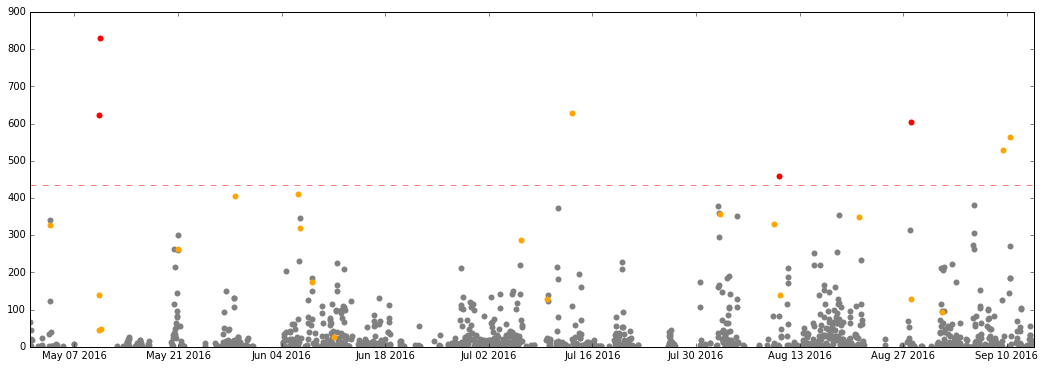

time: 2.25 s


In [33]:
# t.head()
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_sum, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_sum, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_sum, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 435.5, color='red', linestyle='--', alpha=.5 )

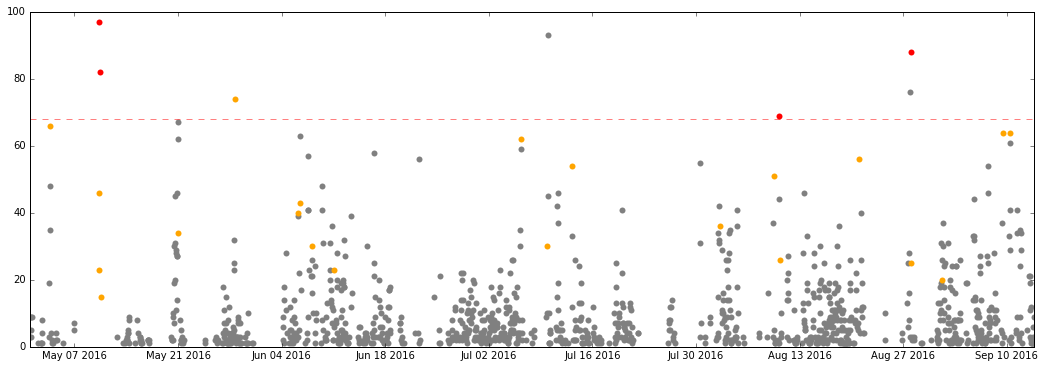

time: 339 ms


In [34]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_max, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_max, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_max, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 68, color='red', linestyle='--', alpha=.5 )

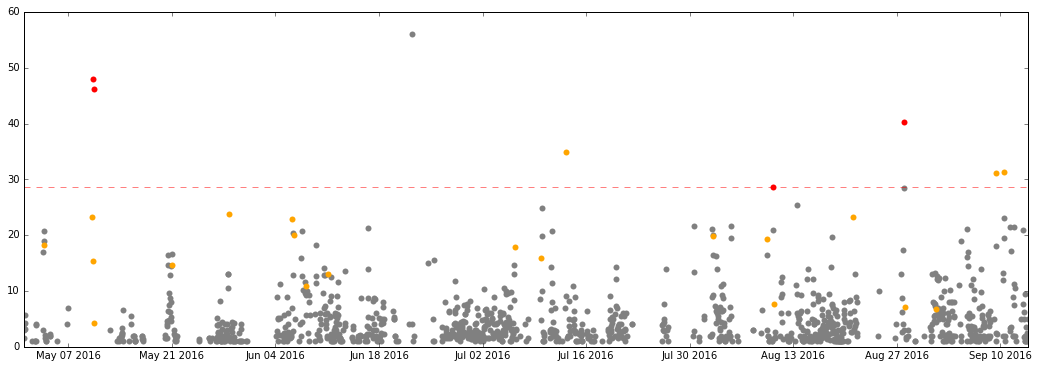

time: 27.6 s


In [35]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].rainfall_mean, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].rainfall_mean, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].rainfall_mean, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 28.5710220337, color='red', linestyle='--', alpha=.5 )

# condition 2
- number of affected areas

In [36]:
t = hdf.groupby( [ 'date', 'signal' ], as_index=False ).agg( { 'amber': 'sum', 'red': 'sum', 'black': 'sum' } )
# t_cols = [ '_'.join( col ).strip( '_' ) for col in t.columns.values ]
# t = pd.DataFrame( t.to_records() ).drop( 'index', axis=1 )
# t.columns = t_cols
t = t.merge( wdf[ [ 'signal', 'st' ] ].groupby( 'st', as_index=False ).max(), how='left', left_on='date', right_on='st', suffixes=[ '_', '' ] )
t = t[ ( t.signal_ == '--' ) | pd.notnull( t.signal ) ]
t = t.drop_duplicates( subset=[ 'date', 'signal' ], keep='last' )
t[ 'areas' ] = t.amber + t.red + t.black
# t.head()

time: 33.6 ms


In [37]:
# t = hdf.groupby( [ 'date', 'signal' ], as_index=False )[ [ 'amber', 'red', 'black', 'rainfall' ] ].sum()
# t[ 'areas' ] = t.amber + t.red + t.black
# t[ ( t.signal == 'Amber' ) & ( t.areas >= 6 ) ]
t[ t.signal == 'Amber' ]

,date,signal_,amber,black,red,st,signal,areas
16,2016-05-03 18:00:00,Amber,1.0,0.0,1.0,2016-05-03 18:00:00,Amber,2.0
29,2016-05-10 06:00:00,Amber,2.0,0.0,0.0,2016-05-10 06:00:00,Amber,2.0
32,2016-05-10 09:00:00,Red,0.0,0.0,0.0,2016-05-10 09:00:00,Amber,0.0
36,2016-05-10 13:00:00,Red,0.0,0.0,0.0,2016-05-10 13:00:00,Amber,0.0
87,2016-05-21 01:00:00,Amber,3.0,0.0,0.0,2016-05-21 01:00:00,Amber,3.0
144,2016-05-28 16:00:00,Amber,1.0,1.0,2.0,2016-05-28 16:00:00,Amber,4.0
203,2016-06-06 06:00:00,Amber,5.0,0.0,0.0,2016-06-06 06:00:00,Amber,5.0
208,2016-06-06 11:00:00,Amber,3.0,0.0,0.0,2016-06-06 11:00:00,Amber,3.0
225,2016-06-08 04:00:00,Amber,1.0,0.0,0.0,2016-06-08 04:00:00,Amber,1.0
260,2016-06-11 03:00:00,Amber,0.0,0.0,0.0,2016-06-11 03:00:00,Amber,0.0


time: 82.6 ms


In [38]:
t[ t.signal == 'Red' ]

,date,signal_,amber,black,red,st,signal,areas
30,2016-05-10 07:00:00,Red,5.0,4.0,1.0,2016-05-10 07:00:00,Red,10.0
34,2016-05-10 11:00:00,Red,6.0,2.0,5.0,2016-05-10 11:00:00,Red,13.0
776,2016-08-10 06:00:00,Red,2.0,0.0,5.0,2016-08-10 06:00:00,Red,7.0
971,2016-08-28 00:00:00,Red,5.0,1.0,4.0,2016-08-28 00:00:00,Red,10.0


time: 45.8 ms


In [39]:
t[ ( t.signal == '--' ) & ( t.areas >= 6 ) ]

,date,signal_,amber,black,red,st,signal,areas


time: 50.3 ms


In [40]:
t[ 'y' ] = ( t.signal == 'Red' ).astype( 'category' ).cat.codes
k = sk.tree.DecisionTreeClassifier( max_depth=1 )
# k.fit( t[ [ 'areas' ] ], t.y )
# p = k.predict_proba( t[ [ 'areas' ] ] )
k.fit( t[ [ 'amber', 'red', 'black', 'areas' ] ], t.y )
p = k.predict_proba( t[ [ 'amber', 'red', 'black', 'areas' ] ] )
print( sk.metrics.classification_report( t.y, np.argmax( p, 1 ) ) )
print( k.tree_.__getstate__()[ 'nodes' ][ 0 ] )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1109
          1       1.00      0.75      0.86         4

avg / total       1.00      1.00      1.00      1113

(1, 2, 1, 3.5, 0.007161948676468355, 1113, 1113.0)
time: 57.3 ms


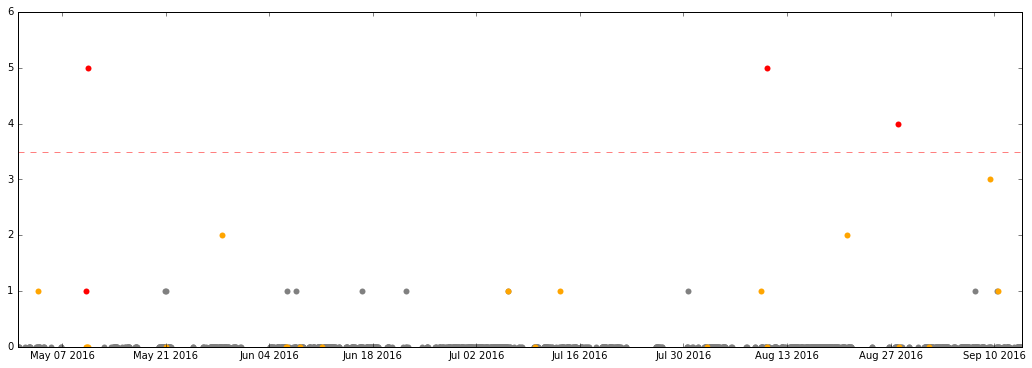

time: 454 ms


In [41]:
# t.head()
pt.figure( figsize=( 18, 6 ) )
pt.ylim( ( 0, 6 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].red, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].red, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].red, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( 3.5, color='red', linestyle='--', alpha=.5 )

# condition 3
- rainfall duration

In [42]:
t = hdf.groupby( [ 'date', 'signal' ], as_index=False ).rainfall.max()
t = t.drop_duplicates( [ 'date', 'signal' ], keep='last' )
for i in [ 30, 50, 70 ]:
    x = t.rainfall > i
    t[ 'r{}'.format( i ) ] = x * x.groupby( ( ( x != x.shift() ) ).cumsum() ).cumcount( ascending=False )
t = t.merge( wdf[ [ 'signal', 'st' ] ].groupby( 'st', as_index=False ).max(), how='left', left_on='date', right_on='st', suffixes=[ '_', '' ] )
t = t[ ( t.signal_ == '--' ) | pd.notnull( t.signal ) ]
t = t.drop_duplicates( subset=[ 'date', 'signal' ], keep='last' )
t[ 'y' ] = t.signal.astype( 'category' ).cat.codes
# t.head()

time: 64.4 ms


In [43]:
t[ t.signal == 'Amber' ]

,date,signal_,rainfall,r30,r50,r70,st,signal,y
16,2016-05-03 18:00:00,Amber,66,2,0,0,2016-05-03 18:00:00,Amber,0
29,2016-05-10 06:00:00,Amber,46,2,0,0,2016-05-10 06:00:00,Amber,0
32,2016-05-10 09:00:00,Red,23,0,0,0,2016-05-10 09:00:00,Amber,0
36,2016-05-10 13:00:00,Red,15,0,0,0,2016-05-10 13:00:00,Amber,0
87,2016-05-21 01:00:00,Amber,34,4,0,0,2016-05-21 01:00:00,Amber,0
144,2016-05-28 16:00:00,Amber,74,1,0,0,2016-05-28 16:00:00,Amber,0
203,2016-06-06 06:00:00,Amber,40,1,0,0,2016-06-06 06:00:00,Amber,0
208,2016-06-06 11:00:00,Amber,43,0,0,0,2016-06-06 11:00:00,Amber,0
225,2016-06-08 04:00:00,Amber,30,0,0,0,2016-06-08 04:00:00,Amber,0
260,2016-06-11 03:00:00,Amber,23,0,0,0,2016-06-11 03:00:00,Amber,0


time: 37.8 ms


In [44]:
t[ t.signal == 'Red' ]

,date,signal_,rainfall,r30,r50,r70,st,signal,y
30,2016-05-10 07:00:00,Red,97,1,0,0,2016-05-10 07:00:00,Red,1
34,2016-05-10 11:00:00,Red,82,1,1,0,2016-05-10 11:00:00,Red,1
776,2016-08-10 06:00:00,Red,69,1,1,0,2016-08-10 06:00:00,Red,1
971,2016-08-28 00:00:00,Red,88,1,1,1,2016-08-28 00:00:00,Red,1


time: 91.8 ms


In [45]:
t[ t.signal == 'Red' ].r30.mean(), t[ t.signal =='Red' ].r50.mean(), t[ t.signal =='Red' ].r70.mean()

(1.0, 0.75, 0.25)

time: 61.6 ms


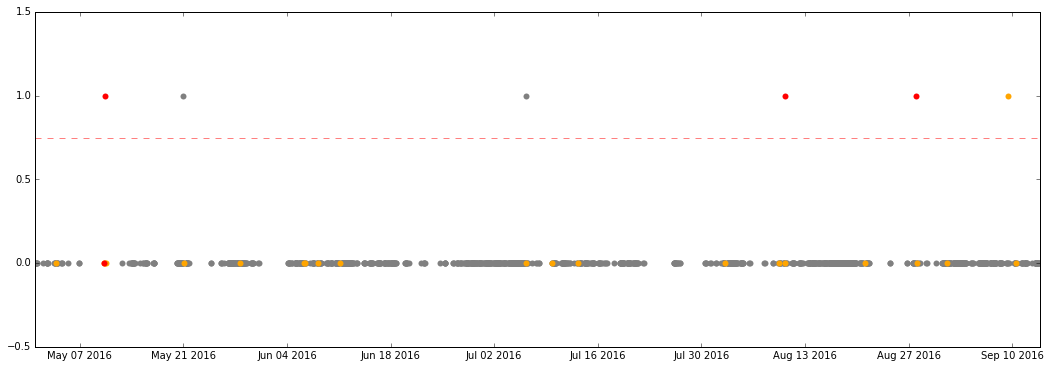

time: 2.43 s


In [46]:
# t.head()
pt.figure( figsize=( 18, 6 ) )
pt.ylim( ( -.5, 1.5 ) )
pt.plot_date( t[ pd.isnull( t.signal ) ].date, t[ pd.isnull( t.signal ) ].r50, color='gray', mew=0 )
pt.plot_date( t[ t.signal == 'Amber' ].date, t[ t.signal == 'Amber' ].r50, color='orange', mew=0 )
pt.plot_date( t[ t.signal == 'Red' ].date, t[ t.signal == 'Red' ].r50, color='red', mew=0 )
# pt.axhline( 30, color='orange', linestyle='--', alpha=.5 )
pt.axhline( .75, color='red', linestyle='--', alpha=.5 )

# condition 4
- time between rainfall reaching threshold and signal raising

In [47]:
# hdf.groupby( [ hdf.date, hdf.signal ] ).head()
t = hdf.groupby( [ 'date', 'signal' ], as_index=False ).agg( { 'rainfall': [ 'sum', 'max', 'mean' ] } )
t_cols = [ '_'.join( col ).strip( '_' ) for col in t.columns.values ]
t = pd.DataFrame( t.to_records() ).drop( 'index', axis=1 )
t.columns = t_cols
# t[ 'check_sum' ] = t.rainfall_sum >= 435
# t[ 'check_max' ] = t.rainfall_max >= 68
# t[ 'check_mean' ] = t.rainfall_mean >= 28
# t[ ( t.signal == 'Amber' ) ]#& ( t.rainfall >= 420 ) ]
t = t.merge( wdf[ [ 'signal', 'st' ] ].groupby( 'st', as_index=False ).max(), how='left', left_on='date', right_on='st', suffixes=[ '_', '' ] )
t = t[ ( t.signal_ == '--' ) | pd.notnull( t.signal ) ]
t = t.drop_duplicates( subset=[ 'date', 'signal' ], keep='last' )
t.head()

,date,signal_,rainfall_sum,rainfall_max,rainfall_mean,st,signal
0,2016-05-01 00:00:00,--,66,9,4.125000,NaT,NaN
1,2016-05-01 01:00:00,--,5,3,1.666667,NaT,NaN
2,2016-05-01 02:00:00,--,3,3,3.000000,NaT,NaN
3,2016-05-01 03:00:00,--,44,5,3.142857,NaT,NaN
4,2016-05-01 04:00:00,--,21,9,4.200000,NaT,NaN


time: 245 ms


# diff in min and max rainfall

In [54]:
t = hdf.groupby( hdf.date, as_index=False ).agg( { 'rainfall': [ 'min', 'max' ] } )
t_cols = [ '_'.join( col ).strip( '_' ) for col in t.columns.values ]
t = pd.DataFrame( t.to_records() ).drop( 'index', axis=1 )
t.columns = t_cols
t[ 'rainfall_diff' ] = t.rainfall_max - t.rainfall_min
t.sort_values( 'rainfall_diff', ascending=False ).head()

,date,rainfall_min,rainfall_max,rainfall_diff
89,2016-05-21 03:00:00,2,122,120
88,2016-05-21 02:00:00,2,110,108
30,2016-05-10 07:00:00,3,97,94
559,2016-07-10 01:00:00,2,93,91
777,2016-08-10 07:00:00,5,94,89


time: 109 ms


In [62]:
hdf[ hdf.date == '2016-05-21 2:0:0' ]

,month,day,hour,region,rainfall,date,signal,amber,red,black
506,5,21,2,Sai Kung,110,2016-05-21 02:00:00,Amber,False,False,True
507,5,21,2,Kwai Tsing,52,2016-05-21 02:00:00,Amber,False,True,False
508,5,21,2,Yuen Long,49,2016-05-21 02:00:00,Amber,True,False,False
509,5,21,2,Tsuen Wan,48,2016-05-21 02:00:00,Amber,True,False,False
510,5,21,2,Tai Po,43,2016-05-21 02:00:00,Amber,True,False,False
511,5,21,2,Kwun Tong,30,2016-05-21 02:00:00,Amber,True,False,False
512,5,21,2,North District,22,2016-05-21 02:00:00,Amber,False,False,False
513,5,21,2,Eastern District,19,2016-05-21 02:00:00,Amber,False,False,False
514,5,21,2,Islands District,16,2016-05-21 02:00:00,Amber,False,False,False
515,5,21,2,Sha Tin,15,2016-05-21 02:00:00,Amber,False,False,False


time: 142 ms


In [55]:
hdf[ hdf.date == '2016-05-21 3:0:0' ]

,month,day,hour,region,rainfall,date,signal,amber,red,black
524,5,21,3,Sai Kung,122,2016-05-21 03:00:00,Amber,False,False,True
525,5,21,3,Tuen Mun,48,2016-05-21 03:00:00,Amber,True,False,False
526,5,21,3,Yuen Long,34,2016-05-21 03:00:00,Amber,True,False,False
527,5,21,3,Tai Po,27,2016-05-21 03:00:00,Amber,False,False,False
528,5,21,3,Tsuen Wan,24,2016-05-21 03:00:00,Amber,False,False,False
529,5,21,3,North District,21,2016-05-21 03:00:00,Amber,False,False,False
530,5,21,3,Kwai Tsing,11,2016-05-21 03:00:00,Amber,False,False,False
531,5,21,3,Sha Tin,11,2016-05-21 03:00:00,Amber,False,False,False
532,5,21,3,Islands District,7,2016-05-21 03:00:00,Amber,False,False,False
533,5,21,3,Sham Shui Po,5,2016-05-21 03:00:00,Amber,False,False,False


time: 44.5 ms


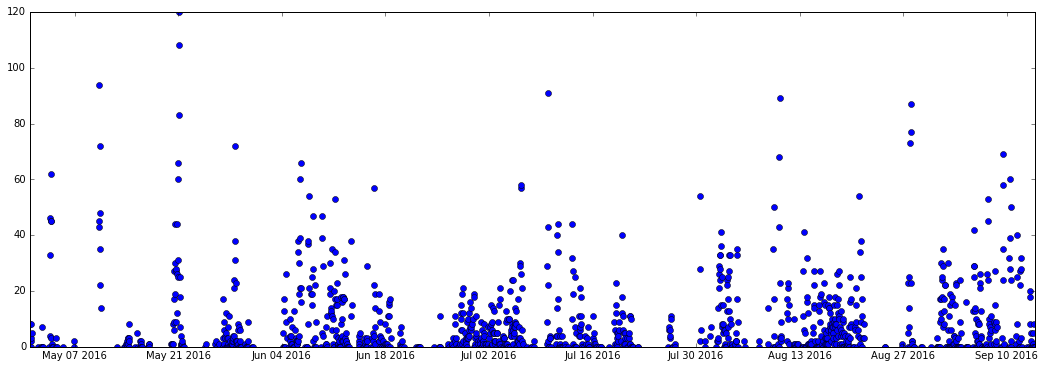

time: 640 ms


In [53]:
pt.figure( figsize=( 18, 6 ) )
pt.plot_date( t.date, t.rainfall_diff )